In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

Поскольку в задании требуется предсказывать метки 'Adoption' и 'Transfer', остальные данные пока проигнорируем.

Проверим также количество данных по разным видам животных

In [3]:
data = pd.read_csv('aac_shelter_outcomes.csv')
data = data[data['outcome_type'].isin(['Adoption', 'Transfer'])]
# cats_data = data[data['animal_type'] == 'Cat']
# dogs_data = data[data['animal_type'] == 'Dog']
# cats_data['age_upon_outcome'].value_counts().head(20)
data['animal_type'].value_counts()

Dog          29570
Cat          26055
Other          772
Bird           206
Livestock        8
Name: animal_type, dtype: int64

С точки зрения вида животных видим, что собак и кошек в данных подавляющее большинство (98%).
Другие виды животных можно детальнее посмотреть позже, пока же исключим их из данных.

In [12]:
data = data[data['animal_type'].isin(['Dog', 'Cat'])]
data

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
5,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,Transfer,Intact Male
...,...,...,...,...,...,...,...,...,...,...,...,...
78250,1 month,A764895,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:40:00,2018-02-01T18:40:00,NaN,Foster,Adoption,Neutered Male
78251,1 month,A764894,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:26:00,2018-02-01T18:26:00,NaN,Foster,Adoption,Spayed Female
78252,3 years,A764468,Dog,Mastiff Mix,Blue/White,2014-12-30T00:00:00,2018-02-01T18:06:00,2018-02-01T18:06:00,Max,NaN,Adoption,Neutered Male
78254,2 months,A765858,Dog,Standard Schnauzer,Red,2017-11-13T00:00:00,2018-02-01T18:32:00,2018-02-01T18:32:00,NaN,NaN,Adoption,Spayed Female


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55625 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  55624 non-null  object
 1   animal_id         55625 non-null  object
 2   animal_type       55625 non-null  object
 3   breed             55625 non-null  object
 4   color             55625 non-null  object
 5   date_of_birth     55625 non-null  object
 6   datetime          55625 non-null  object
 7   monthyear         55625 non-null  object
 8   name              38196 non-null  object
 9   outcome_subtype   28725 non-null  object
 10  outcome_type      55625 non-null  object
 11  sex_upon_outcome  55625 non-null  object
dtypes: object(12)
memory usage: 5.5+ MB


Один из ключевых параметром, которые нас будут интересовать это 'age_upon_outcome', проверим корректность зачений этого поля

In [5]:
data['age_upon_outcome'].value_counts()

1 year       9318
2 months     8830
2 years      7019
3 months     3209
3 years      2983
1 month      2889
4 months     2158
4 years      1625
5 months     1525
5 years      1499
3 weeks      1387
6 months     1356
2 weeks      1208
10 months    1005
6 years       987
8 months      955
8 years       851
7 years       795
4 weeks       765
7 months      758
10 years      594
9 months      484
1 weeks       456
1 week        400
9 years       391
11 months     369
12 years      282
3 days        214
11 years      194
2 days        193
13 years      141
6 days        138
4 days        119
1 day         119
5 days         89
14 years       83
15 years       77
0 years        71
5 weeks        47
16 years       21
17 years       14
18 years        2
19 years        2
20 years        2
Name: age_upon_outcome, dtype: int64

В целом нас все устраивает - допускаем, что в приют могут попасть как новорожденные животные (несколько дней), так и старые (15-20 лет). Исключение составляют записи со значением '0 years' - посмотрим на них внимательнее

In [6]:
test_data =  data[data['age_upon_outcome'] == '0 years']
# data[data['age_upon_outcome'] == '0 years'].sample(10)

def check_dates(row):
    date_of_birth = row['date_of_birth']
    year_db = int(date_of_birth[:4])
    month_db = int(date_of_birth[5:7])
    day_db = int(date_of_birth[8:10])
    
    datetime = row['datetime']
    year_dt = int(datetime[:4])
    month_dt = int(datetime[5:7])
    day_dt = int(datetime[8:10])
    
    if (year_db - year_dt != 0) or (month_db - month_dt != 0) or (day_db - day_dt != 0):
        print(f'{date_of_birth} - {datetime}')
        return 1
    else:
        return 0

# cat_breed_clear(test_data, cat_top_breed_list)


test_data['date_error'] = test_data.apply(check_dates, axis=1)

# stats.head()
# cats_data[cats_data['breed'] == 'cat_other

2014-04-03T00:00:00 - 2013-12-01T13:19:00
2014-12-12T00:00:00 - 2014-09-10T17:29:00
2016-11-15T00:00:00 - 2016-11-05T18:16:00
2015-07-06T00:00:00 - 2015-07-05T14:46:00
2016-10-28T00:00:00 - 2016-10-04T15:13:00
2015-08-29T00:00:00 - 2015-05-24T17:01:00


C:\Users\Peter\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
# df = df.drop(np.where(df['STP'] == 1005092)[0])

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,date_error
12489,0 years,A666607,Dog,Beagle/Chihuahua Shorthair,White,2013-11-04T00:00:00,2013-11-04T15:01:00,2013-11-04T15:01:00,NaN,Partner,Transfer,Intact Female,0
76489,0 years,A730076,Cat,Domestic Shorthair Mix,Calico,2016-06-28T00:00:00,2016-06-28T11:34:00,2016-06-28T11:34:00,NaN,Partner,Transfer,Unknown,0
2101,0 years,A666602,Dog,Beagle/Chihuahua Shorthair,White,2013-11-04T00:00:00,2013-11-04T14:55:00,2013-11-04T14:55:00,NaN,Partner,Transfer,Intact Female,0
71283,0 years,A750150,Cat,Domestic Shorthair Mix,Brown Tabby/White,2017-05-23T00:00:00,2017-05-23T18:16:00,2017-05-23T18:16:00,NaN,Partner,Transfer,Intact Male,0
7609,0 years,A666601,Dog,Beagle/Chihuahua Shorthair,White,2013-11-04T00:00:00,2013-11-04T14:55:00,2013-11-04T14:55:00,NaN,Partner,Transfer,Intact Male,0
31496,0 years,A735467,Dog,Pug Mix,Brown,2016-09-24T00:00:00,2016-09-24T13:40:00,2016-09-24T13:40:00,Ol'Roy,Partner,Transfer,Intact Male,0
64745,0 years,A702326,Cat,Domestic Shorthair Mix,Black,2015-08-29T00:00:00,2015-05-24T17:01:00,2015-05-24T17:01:00,Penelope,NaN,Adoption,Spayed Female,1
52977,0 years,A736114,Cat,Domestic Shorthair Mix,Orange Tabby,2016-10-28T00:00:00,2016-10-04T15:13:00,2016-10-04T15:13:00,NaN,Partner,Transfer,Intact Male,1
21533,0 years,A677464,Cat,Domestic Shorthair Mix,Blue,2014-04-25T00:00:00,2014-04-25T15:18:00,2014-04-25T15:18:00,NaN,Partner,Transfer,Unknown,0
19814,0 years,A660928,Dog,Labrador Retriever Mix,Black/White,2014-04-03T00:00:00,2013-12-01T13:19:00,2013-12-01T13:19:00,Sadie,Partner,Transfer,Spayed Female,1


In [46]:
for column in data.columns:
    bdate = data[column]
    print(pd.isnull(bdate).value_counts())

False    55624
True         1
Name: age_upon_outcome, dtype: int64
False    55625
Name: animal_id, dtype: int64
False    55625
Name: animal_type, dtype: int64
False    55625
Name: breed, dtype: int64
False    55625
Name: color, dtype: int64
False    55625
Name: date_of_birth, dtype: int64
False    55625
Name: datetime, dtype: int64
False    55625
Name: monthyear, dtype: int64
False    38196
True     17429
Name: name, dtype: int64
False    28725
True     26900
Name: outcome_subtype, dtype: int64
False    55625
Name: outcome_type, dtype: int64
False    55625
Name: sex_upon_outcome, dtype: int64


In [47]:
data.dropna(subset=['age_upon_outcome'], inplace=True)
# data[data['age_upon_outcome'].isnull()]

Преобразуем категориальное поле 'animal_type' в поля со значениями признака 'Dog' и 'Cat'

In [53]:
oh_enc = OneHotEncoder()
ohe_animal_type = oh_enc.fit_transform(data[['animal_type']]).toarray()
ohe_animal_type = pd.DataFrame(ohe_animal_type, columns=oh_enc.categories_[0])

data = data.reset_index(drop=True)
data = data.join(ohe_animal_type)
# data.drop(['animal_type'], axis=1, inplace=True)

data.head(10)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,...,Neutered Male,Spayed Female,Unknown,empty_name,year,month,Adoption,age_weeks,Cat,Dog
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,...,0.0,0.0,0.0,1,2014,07,0,2.00,1.0,0.0
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,...,0.0,1.0,0.0,0,2013,11,0,52.00,0.0,1.0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,...,1.0,0.0,0.0,0,2014,06,1,52.00,0.0,1.0
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,...,1.0,0.0,0.0,0,2014,06,0,468.00,0.0,1.0
4,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,...,0.0,0.0,0.0,0,2013,10,0,17.32,0.0,1.0
5,3 years,A692618,Dog,Chihuahua Shorthair Mix,Brown,2011-11-23T00:00:00,2014-12-08T15:55:00,2014-12-08T15:55:00,*Ella,Partner,...,0.0,1.0,0.0,0,2014,12,0,156.00,0.0,1.0
6,1 month,A685067,Cat,Domestic Shorthair Mix,Blue Tabby/White,2014-06-16T00:00:00,2014-08-14T18:45:00,2014-08-14T18:45:00,Lucy,NaN,...,0.0,0.0,0.0,0,2014,08,1,4.33,1.0,0.0
7,3 months,A678580,Cat,Domestic Shorthair Mix,White/Black,2014-03-26T00:00:00,2014-06-29T17:45:00,2014-06-29T17:45:00,*Frida,Offsite,...,0.0,1.0,0.0,0,2014,06,1,12.99,1.0,0.0
8,2 years,A673652,Dog,Papillon/Border Collie,Black/White,2012-02-28T00:00:00,2014-03-28T14:39:00,2014-03-28T14:39:00,Fancy,Partner,...,1.0,0.0,0.0,0,2014,03,0,104.00,0.0,1.0
9,2 months,A677679,Dog,Chihuahua Shorthair/Pomeranian,Black,2014-03-07T00:00:00,2014-05-26T19:10:00,2014-05-26T19:10:00,Kash,Foster,...,1.0,0.0,0.0,0,2014,05,1,8.66,0.0,1.0


Преобразуем категориальное поле 'sex_upon_outcome' в поля с соответствующими значениями признака

In [48]:
oh_enc = OneHotEncoder()
ohe_sex_upon_outcome = oh_enc.fit_transform(data[['sex_upon_outcome']]).toarray()
ohe_sex_upon_outcome = pd.DataFrame(ohe_sex_upon_outcome, columns=oh_enc.categories_[0])

data = data.reset_index(drop=True)
data = data.join(ohe_sex_upon_outcome)
# data.drop(['sex_upon_outcome'], axis=1, inplace=True)

data.head(10)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,0.0,1.0,0.0,0.0,0.0
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,0.0,0.0,0.0,1.0,0.0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,0.0,0.0,1.0,0.0,0.0
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,0.0,0.0,1.0,0.0,0.0
4,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,Transfer,Intact Male,0.0,1.0,0.0,0.0,0.0
5,3 years,A692618,Dog,Chihuahua Shorthair Mix,Brown,2011-11-23T00:00:00,2014-12-08T15:55:00,2014-12-08T15:55:00,*Ella,Partner,Transfer,Spayed Female,0.0,0.0,0.0,1.0,0.0
6,1 month,A685067,Cat,Domestic Shorthair Mix,Blue Tabby/White,2014-06-16T00:00:00,2014-08-14T18:45:00,2014-08-14T18:45:00,Lucy,NaN,Adoption,Intact Female,1.0,0.0,0.0,0.0,0.0
7,3 months,A678580,Cat,Domestic Shorthair Mix,White/Black,2014-03-26T00:00:00,2014-06-29T17:45:00,2014-06-29T17:45:00,*Frida,Offsite,Adoption,Spayed Female,0.0,0.0,0.0,1.0,0.0
8,2 years,A673652,Dog,Papillon/Border Collie,Black/White,2012-02-28T00:00:00,2014-03-28T14:39:00,2014-03-28T14:39:00,Fancy,Partner,Transfer,Neutered Male,0.0,0.0,1.0,0.0,0.0
9,2 months,A677679,Dog,Chihuahua Shorthair/Pomeranian,Black,2014-03-07T00:00:00,2014-05-26T19:10:00,2014-05-26T19:10:00,Kash,Foster,Adoption,Neutered Male,0.0,0.0,1.0,0.0,0.0


In [49]:
# Добавим признак 'empty_name' для животных, у которых не было имени
data.loc[:, 'empty_name'] = 1 * pd.isnull(data['name'])
data

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,empty_name
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,0.0,1.0,0.0,0.0,0.0,1
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,0.0,0.0,0.0,1.0,0.0,0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,0.0,0.0,1.0,0.0,0.0,0
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,0.0,0.0,1.0,0.0,0.0,0
4,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,Transfer,Intact Male,0.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55619,1 month,A764895,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:40:00,2018-02-01T18:40:00,NaN,Foster,Adoption,Neutered Male,0.0,0.0,1.0,0.0,0.0,1
55620,1 month,A764894,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:26:00,2018-02-01T18:26:00,NaN,Foster,Adoption,Spayed Female,0.0,0.0,0.0,1.0,0.0,1
55621,3 years,A764468,Dog,Mastiff Mix,Blue/White,2014-12-30T00:00:00,2018-02-01T18:06:00,2018-02-01T18:06:00,Max,NaN,Adoption,Neutered Male,0.0,0.0,1.0,0.0,0.0,0
55622,2 months,A765858,Dog,Standard Schnauzer,Red,2017-11-13T00:00:00,2018-02-01T18:32:00,2018-02-01T18:32:00,NaN,NaN,Adoption,Spayed Female,0.0,0.0,0.0,1.0,0.0,1


In [50]:
def get_year(row):
    date_string = row['datetime']
    return date_string[:4]

def get_month(row):
    date_string = row['datetime']
    return date_string[5:7]


data['year'] = data.apply(get_year, axis=1)
data['month'] = data.apply(get_month, axis=1)

# stats.head()
# data['year'].value_counts()
data.sample(5)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,empty_name,year,month
34662,1 month,A705747,Cat,Domestic Shorthair Mix,Blue Tabby/White,2015-04-28T00:00:00,2015-06-27T17:08:00,2015-06-27T17:08:00,Mimzy,NaN,Adoption,Neutered Male,0.0,0.0,1.0,0.0,0.0,0,2015,06
38856,2 months,A749374,Dog,Australian Cattle Dog Mix,Blue Merle,2017-02-27T00:00:00,2017-05-18T18:24:00,2017-05-18T18:24:00,NaN,NaN,Adoption,Spayed Female,0.0,0.0,0.0,1.0,0.0,1,2017,05
46421,2 years,A709553,Dog,American Staffordshire Terrier Mix,Blue/White,2015-04-10T00:00:00,2017-04-11T13:28:00,2017-04-11T13:28:00,Kayden,Partner,Transfer,Neutered Male,0.0,0.0,1.0,0.0,0.0,0,2017,04
50533,1 year,A721193,Dog,Dachshund Mix,Black,2015-02-23T00:00:00,2016-02-27T18:02:00,2016-02-27T18:02:00,Hershey,NaN,Adoption,Neutered Male,0.0,0.0,1.0,0.0,0.0,0,2016,02
9565,3 days,A692362,Dog,Yorkshire Terrier Mix,Tricolor,2014-11-18T00:00:00,2014-11-21T16:21:00,2014-11-21T16:21:00,NaN,Partner,Transfer,Intact Female,1.0,0.0,0.0,0.0,0.0,1,2014,11


Преобразуем категориальное поле 'month' в поля с соответствующими значениями признака

In [258]:
ohe_month = oh_enc.fit_transform(data[['month']]).toarray()
ohe_month = pd.DataFrame(ohe_month, columns=oh_enc.categories_[0])

data = data.reset_index(drop=True)
data = data.join(ohe_month)
# data.drop(['sex_upon_outcome'], axis=1, inplace=True)

data.head(10)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,...,03,04,05,06,07,08,09,10,11,12
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,3 years,A692618,Dog,Chihuahua Shorthair Mix,Brown,2011-11-23T00:00:00,2014-12-08T15:55:00,2014-12-08T15:55:00,*Ella,Partner,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,1 month,A685067,Cat,Domestic Shorthair Mix,Blue Tabby/White,2014-06-16T00:00:00,2014-08-14T18:45:00,2014-08-14T18:45:00,Lucy,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,3 months,A678580,Cat,Domestic Shorthair Mix,White/Black,2014-03-26T00:00:00,2014-06-29T17:45:00,2014-06-29T17:45:00,*Frida,Offsite,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2 years,A673652,Dog,Papillon/Border Collie,Black/White,2012-02-28T00:00:00,2014-03-28T14:39:00,2014-03-28T14:39:00,Fancy,Partner,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2 months,A677679,Dog,Chihuahua Shorthair/Pomeranian,Black,2014-03-07T00:00:00,2014-05-26T19:10:00,2014-05-26T19:10:00,Kash,Foster,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [275]:
ohe_year = oh_enc.fit_transform(data[['year']]).toarray()
ohe_year = pd.DataFrame(ohe_year, columns=oh_enc.categories_[0])

data = data.reset_index(drop=True)
data = data.join(ohe_year)
data.head(10)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,...,Spayed Female,Unknown,empty_name,year,2013,2014,2015,2016,2017,2018
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,...,0.0,0.0,1,2014,0.0,1.0,0.0,0.0,0.0,0.0
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,...,1.0,0.0,0,2013,1.0,0.0,0.0,0.0,0.0,0.0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,...,0.0,0.0,0,2014,0.0,1.0,0.0,0.0,0.0,0.0
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,...,0.0,0.0,0,2014,0.0,1.0,0.0,0.0,0.0,0.0
4,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,...,0.0,0.0,0,2013,1.0,0.0,0.0,0.0,0.0,0.0
5,3 years,A692618,Dog,Chihuahua Shorthair Mix,Brown,2011-11-23T00:00:00,2014-12-08T15:55:00,2014-12-08T15:55:00,*Ella,Partner,...,1.0,0.0,0,2014,0.0,1.0,0.0,0.0,0.0,0.0
6,1 month,A685067,Cat,Domestic Shorthair Mix,Blue Tabby/White,2014-06-16T00:00:00,2014-08-14T18:45:00,2014-08-14T18:45:00,Lucy,NaN,...,0.0,0.0,0,2014,0.0,1.0,0.0,0.0,0.0,0.0
7,3 months,A678580,Cat,Domestic Shorthair Mix,White/Black,2014-03-26T00:00:00,2014-06-29T17:45:00,2014-06-29T17:45:00,*Frida,Offsite,...,1.0,0.0,0,2014,0.0,1.0,0.0,0.0,0.0,0.0
8,2 years,A673652,Dog,Papillon/Border Collie,Black/White,2012-02-28T00:00:00,2014-03-28T14:39:00,2014-03-28T14:39:00,Fancy,Partner,...,0.0,0.0,0,2014,0.0,1.0,0.0,0.0,0.0,0.0
9,2 months,A677679,Dog,Chihuahua Shorthair/Pomeranian,Black,2014-03-07T00:00:00,2014-05-26T19:10:00,2014-05-26T19:10:00,Kash,Foster,...,0.0,0.0,0,2014,0.0,1.0,0.0,0.0,0.0,0.0


In [51]:
def transfer(outcome_type):
    if outcome_type == 'Adoption':
        return 1
    else:
        return 0
# data['breed'] = data.apply(cat_breed_clear, axis=1)

data['Adoption'] = data['outcome_type'].apply(transfer)
data

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,...,sex_upon_outcome,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,empty_name,year,month,Adoption
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,...,Intact Male,0.0,1.0,0.0,0.0,0.0,1,2014,07,0
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,...,Spayed Female,0.0,0.0,0.0,1.0,0.0,0,2013,11,0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,...,Neutered Male,0.0,0.0,1.0,0.0,0.0,0,2014,06,1
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,...,Neutered Male,0.0,0.0,1.0,0.0,0.0,0,2014,06,0
4,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,...,Intact Male,0.0,1.0,0.0,0.0,0.0,0,2013,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55619,1 month,A764895,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:40:00,2018-02-01T18:40:00,NaN,Foster,...,Neutered Male,0.0,0.0,1.0,0.0,0.0,1,2018,02,1
55620,1 month,A764894,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:26:00,2018-02-01T18:26:00,NaN,Foster,...,Spayed Female,0.0,0.0,0.0,1.0,0.0,1,2018,02,1
55621,3 years,A764468,Dog,Mastiff Mix,Blue/White,2014-12-30T00:00:00,2018-02-01T18:06:00,2018-02-01T18:06:00,Max,NaN,...,Neutered Male,0.0,0.0,1.0,0.0,0.0,0,2018,02,1
55622,2 months,A765858,Dog,Standard Schnauzer,Red,2017-11-13T00:00:00,2018-02-01T18:32:00,2018-02-01T18:32:00,NaN,NaN,...,Spayed Female,0.0,0.0,0.0,1.0,0.0,1,2018,02,1


In [52]:
def age_to_weeks(df):
    result = {}
    for record in df['age_upon_outcome'].unique():
        if type(record) != type(""):
            result[record] = -1
        else:
            num, period = record.split()
            if period in ["year", "years"]:
                result[record] = int(num) * 52
            elif period in ["month", "months"]:
                result[record] = int(num) * 4.33
            elif period in ["week", "weeks"]:
                result[record] = int(num)
            elif period in ["day", "days"]:
                result[record] = int(num) / 7
                
    df['age_weeks'] = df['age_upon_outcome'].map(result).astype(float)
#     df = df.drop('age_upon_outcome', axis = 1)
                
    return df

data = age_to_weeks(data)
data

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,...,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,empty_name,year,month,Adoption,age_weeks
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,...,0.0,1.0,0.0,0.0,0.0,1,2014,07,0,2.00
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,...,0.0,0.0,0.0,1.0,0.0,0,2013,11,0,52.00
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,...,0.0,0.0,1.0,0.0,0.0,0,2014,06,1,52.00
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,...,0.0,0.0,1.0,0.0,0.0,0,2014,06,0,468.00
4,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,...,0.0,1.0,0.0,0.0,0.0,0,2013,10,0,17.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55619,1 month,A764895,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:40:00,2018-02-01T18:40:00,NaN,Foster,...,0.0,0.0,1.0,0.0,0.0,1,2018,02,1,4.33
55620,1 month,A764894,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:26:00,2018-02-01T18:26:00,NaN,Foster,...,0.0,0.0,0.0,1.0,0.0,1,2018,02,1,4.33
55621,3 years,A764468,Dog,Mastiff Mix,Blue/White,2014-12-30T00:00:00,2018-02-01T18:06:00,2018-02-01T18:06:00,Max,NaN,...,0.0,0.0,1.0,0.0,0.0,0,2018,02,1,156.00
55622,2 months,A765858,Dog,Standard Schnauzer,Red,2017-11-13T00:00:00,2018-02-01T18:32:00,2018-02-01T18:32:00,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,1,2018,02,1,8.66


In [68]:
data

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,...,Neutered Male,Spayed Female,Unknown,empty_name,year,month,Adoption,age_weeks,Cat,Dog
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,...,0.0,0.0,0.0,1,2014,07,0,2.00,1.0,0.0
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,...,0.0,1.0,0.0,0,2013,11,0,52.00,0.0,1.0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,...,1.0,0.0,0.0,0,2014,06,1,52.00,0.0,1.0
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,...,1.0,0.0,0.0,0,2014,06,0,468.00,0.0,1.0
4,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,...,0.0,0.0,0.0,0,2013,10,0,17.32,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55619,1 month,A764895,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:40:00,2018-02-01T18:40:00,NaN,Foster,...,1.0,0.0,0.0,1,2018,02,1,4.33,0.0,1.0
55620,1 month,A764894,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:26:00,2018-02-01T18:26:00,NaN,Foster,...,0.0,1.0,0.0,1,2018,02,1,4.33,0.0,1.0
55621,3 years,A764468,Dog,Mastiff Mix,Blue/White,2014-12-30T00:00:00,2018-02-01T18:06:00,2018-02-01T18:06:00,Max,NaN,...,1.0,0.0,0.0,0,2018,02,1,156.00,0.0,1.0
55622,2 months,A765858,Dog,Standard Schnauzer,Red,2017-11-13T00:00:00,2018-02-01T18:32:00,2018-02-01T18:32:00,NaN,NaN,...,0.0,1.0,0.0,1,2018,02,1,8.66,0.0,1.0


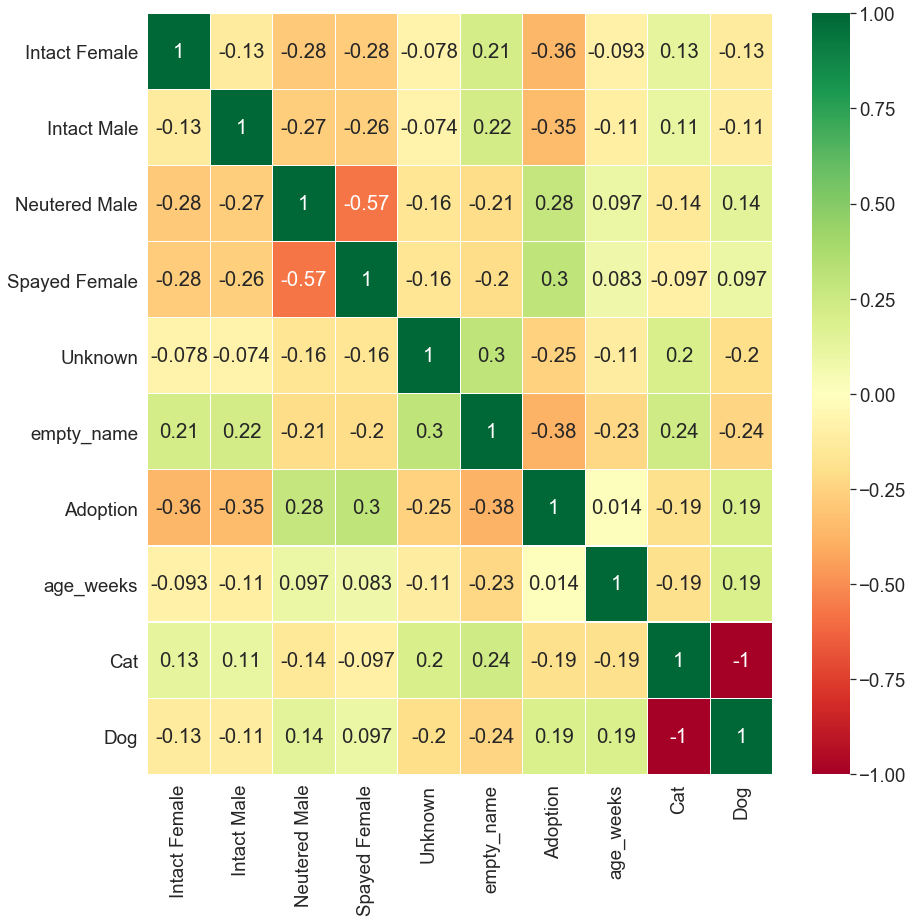

In [59]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(14,14)
plt.show()

In [22]:
data.drop(['age_upon_outcome'], axis=1, inplace=True)
data.drop(['animal_id'], axis=1, inplace=True)
data.drop(['outcome_type'], axis=1, inplace=True)
data.drop(['color'], axis=1, inplace=True)
data.drop(['date_of_birth'], axis=1, inplace=True)
data.drop(['datetime'], axis=1, inplace=True)
data.drop(['monthyear'], axis=1, inplace=True)
data.drop(['name'], axis=1, inplace=True)
data.drop(['outcome_subtype'], axis=1, inplace=True)
data.drop(['sex_upon_outcome'], axis=1, inplace=True)
# data.drop(['year'], axis=1, inplace=True)
data


,animal_type,breed,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,empty_name,Adoption,age_weeks
0,Cat,Domestic Shorthair Mix,0.0,1.0,0.0,0.0,0.0,1,0,2.00
1,Dog,Beagle Mix,0.0,0.0,0.0,1.0,0.0,0,0,52.00
2,Dog,Pit Bull,0.0,0.0,1.0,0.0,0.0,0,1,52.00
3,Dog,Miniature Schnauzer Mix,0.0,0.0,1.0,0.0,0.0,0,0,468.00
4,Dog,Leonberger Mix,0.0,1.0,0.0,0.0,0.0,0,0,17.32
...,...,...,...,...,...,...,...,...,...,...
55619,Dog,Golden Retriever/Labrador Retriever,0.0,0.0,1.0,0.0,0.0,1,1,4.33
55620,Dog,Golden Retriever/Labrador Retriever,0.0,0.0,0.0,1.0,0.0,1,1,4.33
55621,Dog,Mastiff Mix,0.0,0.0,1.0,0.0,0.0,0,1,156.00
55622,Dog,Standard Schnauzer,0.0,0.0,0.0,1.0,0.0,1,1,8.66


In [23]:
dogs_data = data[data['animal_type'] == 'Dog']
dogs_data.drop(['animal_type'], axis=1, inplace=True)
dogs_data.drop(['breed'], axis=1, inplace=True)
# dogs_data.drop(['Cat'], axis=1, inplace=True)
# dogs_data.drop(['Dog'], axis=1, inplace=True)
# dogs_data.drop(['year'], axis=1, inplace=True)
# dogs_data.drop(['month'], axis=1, inplace=True)

C:\Users\Peter\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [24]:
X = dogs_data.drop('Adoption', axis=1)  
y = dogs_data['Adoption'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2020, stratify=y)

,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,empty_name,age_weeks
1,0.0,0.0,0.0,1.0,0.0,0,52.00
2,0.0,0.0,1.0,0.0,0.0,0,52.00
3,0.0,0.0,1.0,0.0,0.0,0,468.00
4,0.0,1.0,0.0,0.0,0.0,0,17.32
5,0.0,0.0,0.0,1.0,0.0,0,156.00
...,...,...,...,...,...,...,...
55619,0.0,0.0,1.0,0.0,0.0,1,4.33
55620,0.0,0.0,0.0,1.0,0.0,1,4.33
55621,0.0,0.0,1.0,0.0,0.0,0,156.00
55622,0.0,0.0,0.0,1.0,0.0,1,8.66


In [25]:
#key
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print(rfc.score(X_train, y_train))

0.8072277514735723


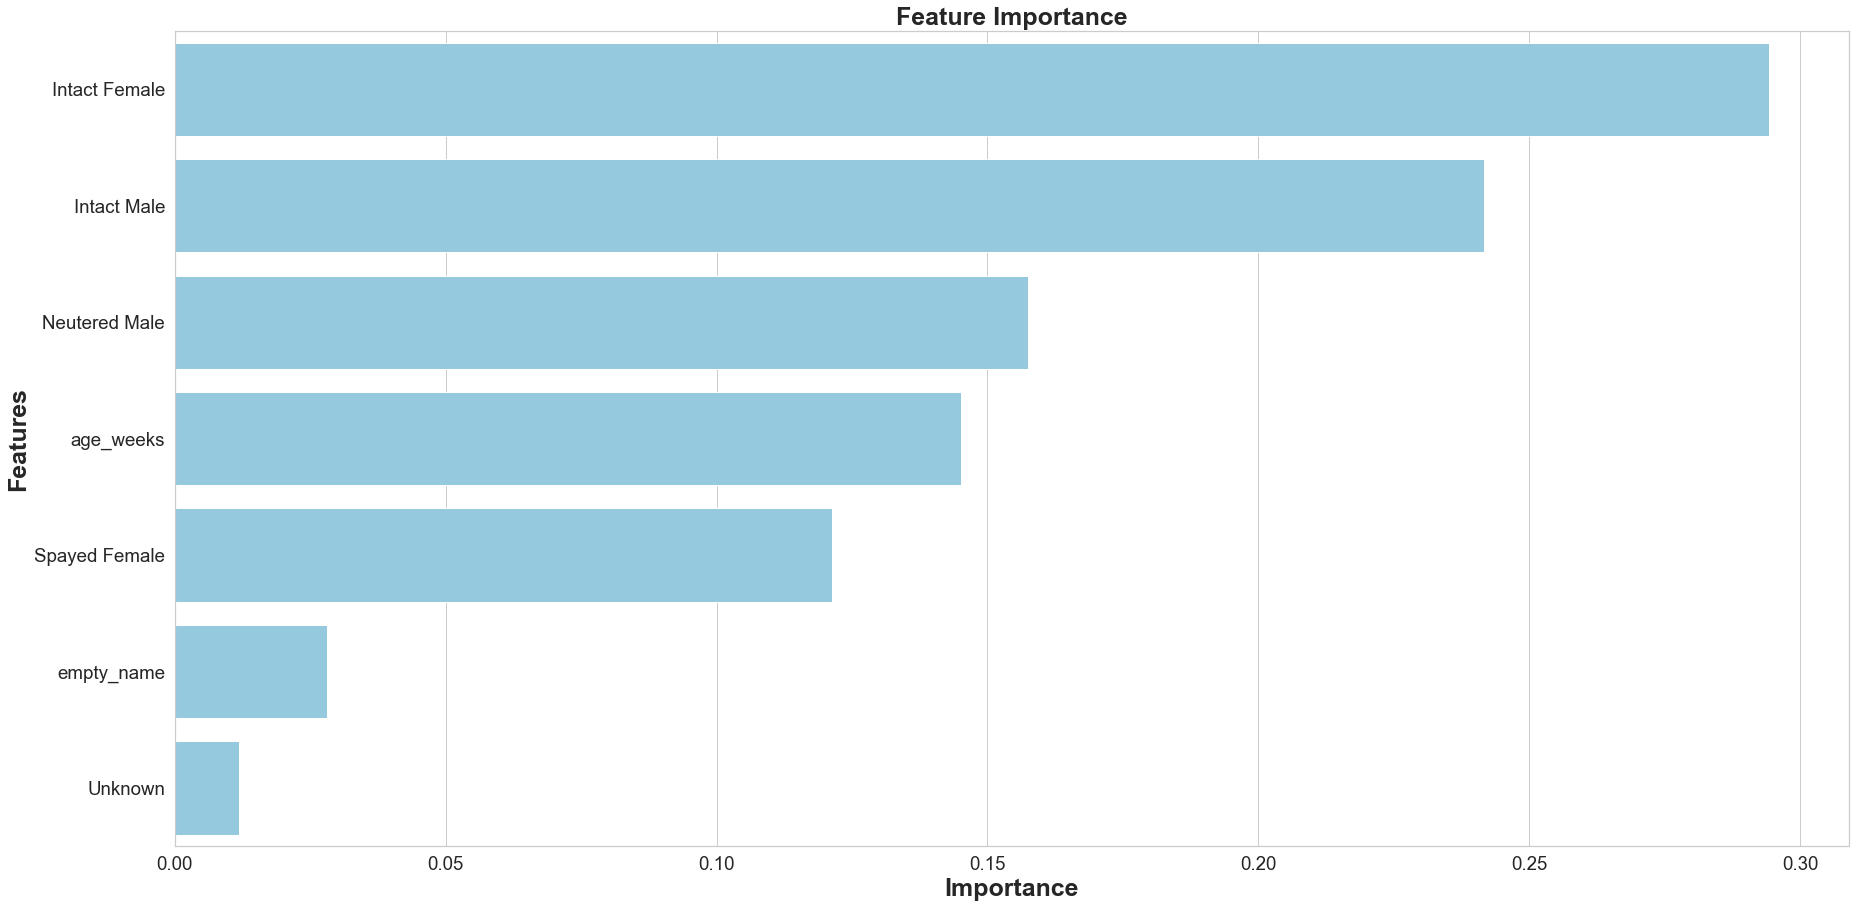

None

,Features,Gini-Importance
0,Intact Female,0.294242
1,Intact Male,0.241693
2,Neutered Male,0.157529
3,age_weeks,0.145149
4,Spayed Female,0.121299
5,empty_name,0.028186
6,Unknown,0.011902


In [26]:
feats = {}
for feature, importance in zip(X.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

In [27]:
y_pred = rfc.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
# conf_matrix_baseline_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_pca), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
# conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_gs), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(conf_matrix_baseline)
# display('Baseline Random Forest recall score', recall_score(y_test, y_pred))

,predicted 0,predicted 1
actual 0,1313,1542
actual 1,182,5834


In [28]:
cats_data = data[data['animal_type'] == 'Cat']
cat_top_breed_list = list(cats_data['breed'].value_counts().head(12).index)
cat_top_breed_list

['Domestic Shorthair Mix',
 'Domestic Medium Hair Mix',
 'Domestic Longhair Mix',
 'Siamese Mix',
 'Domestic Shorthair',
 'American Shorthair Mix',
 'Snowshoe Mix',
 'Domestic Medium Hair',
 'Maine Coon Mix',
 'Manx Mix',
 'Siamese',
 'Russian Blue Mix']

In [111]:
dogs_data = data[data['animal_type'] == 'Dog']
dogs_data['breed'].value_counts().head(30)
# cat_top_breed_list = list(cats_data['breed'].value_counts().head(12).index)
# cat_top_breed_list

Pit Bull Mix                     3509
Chihuahua Shorthair Mix          3399
Labrador Retriever Mix           3258
German Shepherd Mix              1265
Australian Cattle Dog Mix         788
Dachshund Mix                     581
Border Collie Mix                 459
Boxer Mix                         437
Miniature Poodle Mix              392
Catahoula Mix                     336
Rat Terrier Mix                   310
Australian Shepherd Mix           301
Jack Russell Terrier Mix          296
Yorkshire Terrier Mix             282
Beagle Mix                        267
Cairn Terrier Mix                 266
Pointer Mix                       263
Chihuahua Longhair Mix            256
Miniature Schnauzer Mix           246
Staffordshire Mix                 229
Great Pyrenees Mix                226
Siberian Husky Mix                217
Plott Hound Mix                   213
Anatol Shepherd Mix               200
Black Mouth Cur Mix               197
Australian Kelpie Mix             194
American Bul

In [30]:
# test_data = data.sample(1000)

def cat_breed_clear(row):
    if row['animal_type'] == 'Cat':
        if row['breed'] in cat_top_breed_list:
            return row['breed']
        else:
            return 'cat_other'
    else:
        return row['breed']

# cat_breed_clear(test_data, cat_top_breed_list)


cats_data['breed'] = cats_data.apply(cat_breed_clear, axis=1)
# stats.head()
cats_data[cats_data['breed'] == 'cat_other']

C:\Users\Peter\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,animal_type,breed,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,empty_name,Adoption,age_weeks
237,Cat,cat_other,1.0,0.0,0.0,0.0,0.0,1,0,17.32
395,Cat,cat_other,0.0,0.0,1.0,0.0,0.0,0,0,260.00
497,Cat,cat_other,0.0,0.0,0.0,1.0,0.0,0,1,52.00
778,Cat,cat_other,1.0,0.0,0.0,0.0,0.0,0,0,104.00
827,Cat,cat_other,0.0,0.0,0.0,1.0,0.0,0,1,676.00
...,...,...,...,...,...,...,...,...,...,...
53519,Cat,cat_other,0.0,0.0,1.0,0.0,0.0,0,1,104.00
53655,Cat,cat_other,0.0,0.0,0.0,1.0,0.0,0,1,17.32
54706,Cat,cat_other,0.0,0.0,1.0,0.0,0.0,0,1,208.00
55480,Cat,cat_other,0.0,0.0,1.0,0.0,0.0,0,1,416.00


In [31]:
ohe_cat_breed = oh_enc.fit_transform(cats_data[['breed']]).toarray()
ohe_cat_breed = pd.DataFrame(ohe_cat_breed, columns=oh_enc.categories_[0])

cats_data = cats_data.reset_index(drop=True)
cats_data = cats_data.join(ohe_cat_breed)
cats_data.head(10)


,animal_type,breed,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,empty_name,Adoption,age_weeks,...,Domestic Medium Hair Mix,Domestic Shorthair,Domestic Shorthair Mix,Maine Coon Mix,Manx Mix,Russian Blue Mix,Siamese,Siamese Mix,Snowshoe Mix,cat_other
0,Cat,Domestic Shorthair Mix,0.0,1.0,0.0,0.0,0.0,1,0,2.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cat,Domestic Shorthair Mix,1.0,0.0,0.0,0.0,0.0,0,1,4.33,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Cat,Domestic Shorthair Mix,0.0,0.0,0.0,1.0,0.0,0,1,12.99,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cat,Domestic Shorthair Mix,0.0,1.0,0.0,0.0,0.0,1,0,3.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Cat,Domestic Shorthair Mix,0.0,0.0,0.0,1.0,0.0,0,1,8.66,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Cat,Domestic Shorthair Mix,0.0,0.0,0.0,0.0,1.0,1,0,34.64,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Cat,Domestic Shorthair Mix,0.0,0.0,1.0,0.0,0.0,0,1,21.65,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Cat,Domestic Shorthair Mix,0.0,0.0,1.0,0.0,0.0,0,1,8.66,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Cat,Domestic Medium Hair Mix,0.0,0.0,1.0,0.0,0.0,0,0,52.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Cat,Siamese,1.0,0.0,0.0,0.0,0.0,0,0,8.66,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [33]:
cats_data.drop(['animal_type'], axis=1, inplace=True)
cats_data.drop(['breed'], axis=1, inplace=True)
cats_data
# data['outcome_type'].value_counts()

,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,empty_name,Adoption,age_weeks,American Shorthair Mix,Domestic Longhair Mix,...,Domestic Medium Hair Mix,Domestic Shorthair,Domestic Shorthair Mix,Maine Coon Mix,Manx Mix,Russian Blue Mix,Siamese,Siamese Mix,Snowshoe Mix,cat_other
0,0.0,1.0,0.0,0.0,0.0,1,0,2.00,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0,1,4.33,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0,1,12.99,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1,0,3.00,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0,1,8.66,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26050,1.0,0.0,0.0,0.0,0.0,0,1,8.66,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26051,0.0,1.0,0.0,0.0,0.0,0,1,4.33,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26052,0.0,0.0,1.0,0.0,0.0,1,0,52.00,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26053,0.0,0.0,0.0,1.0,0.0,0,1,25.98,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


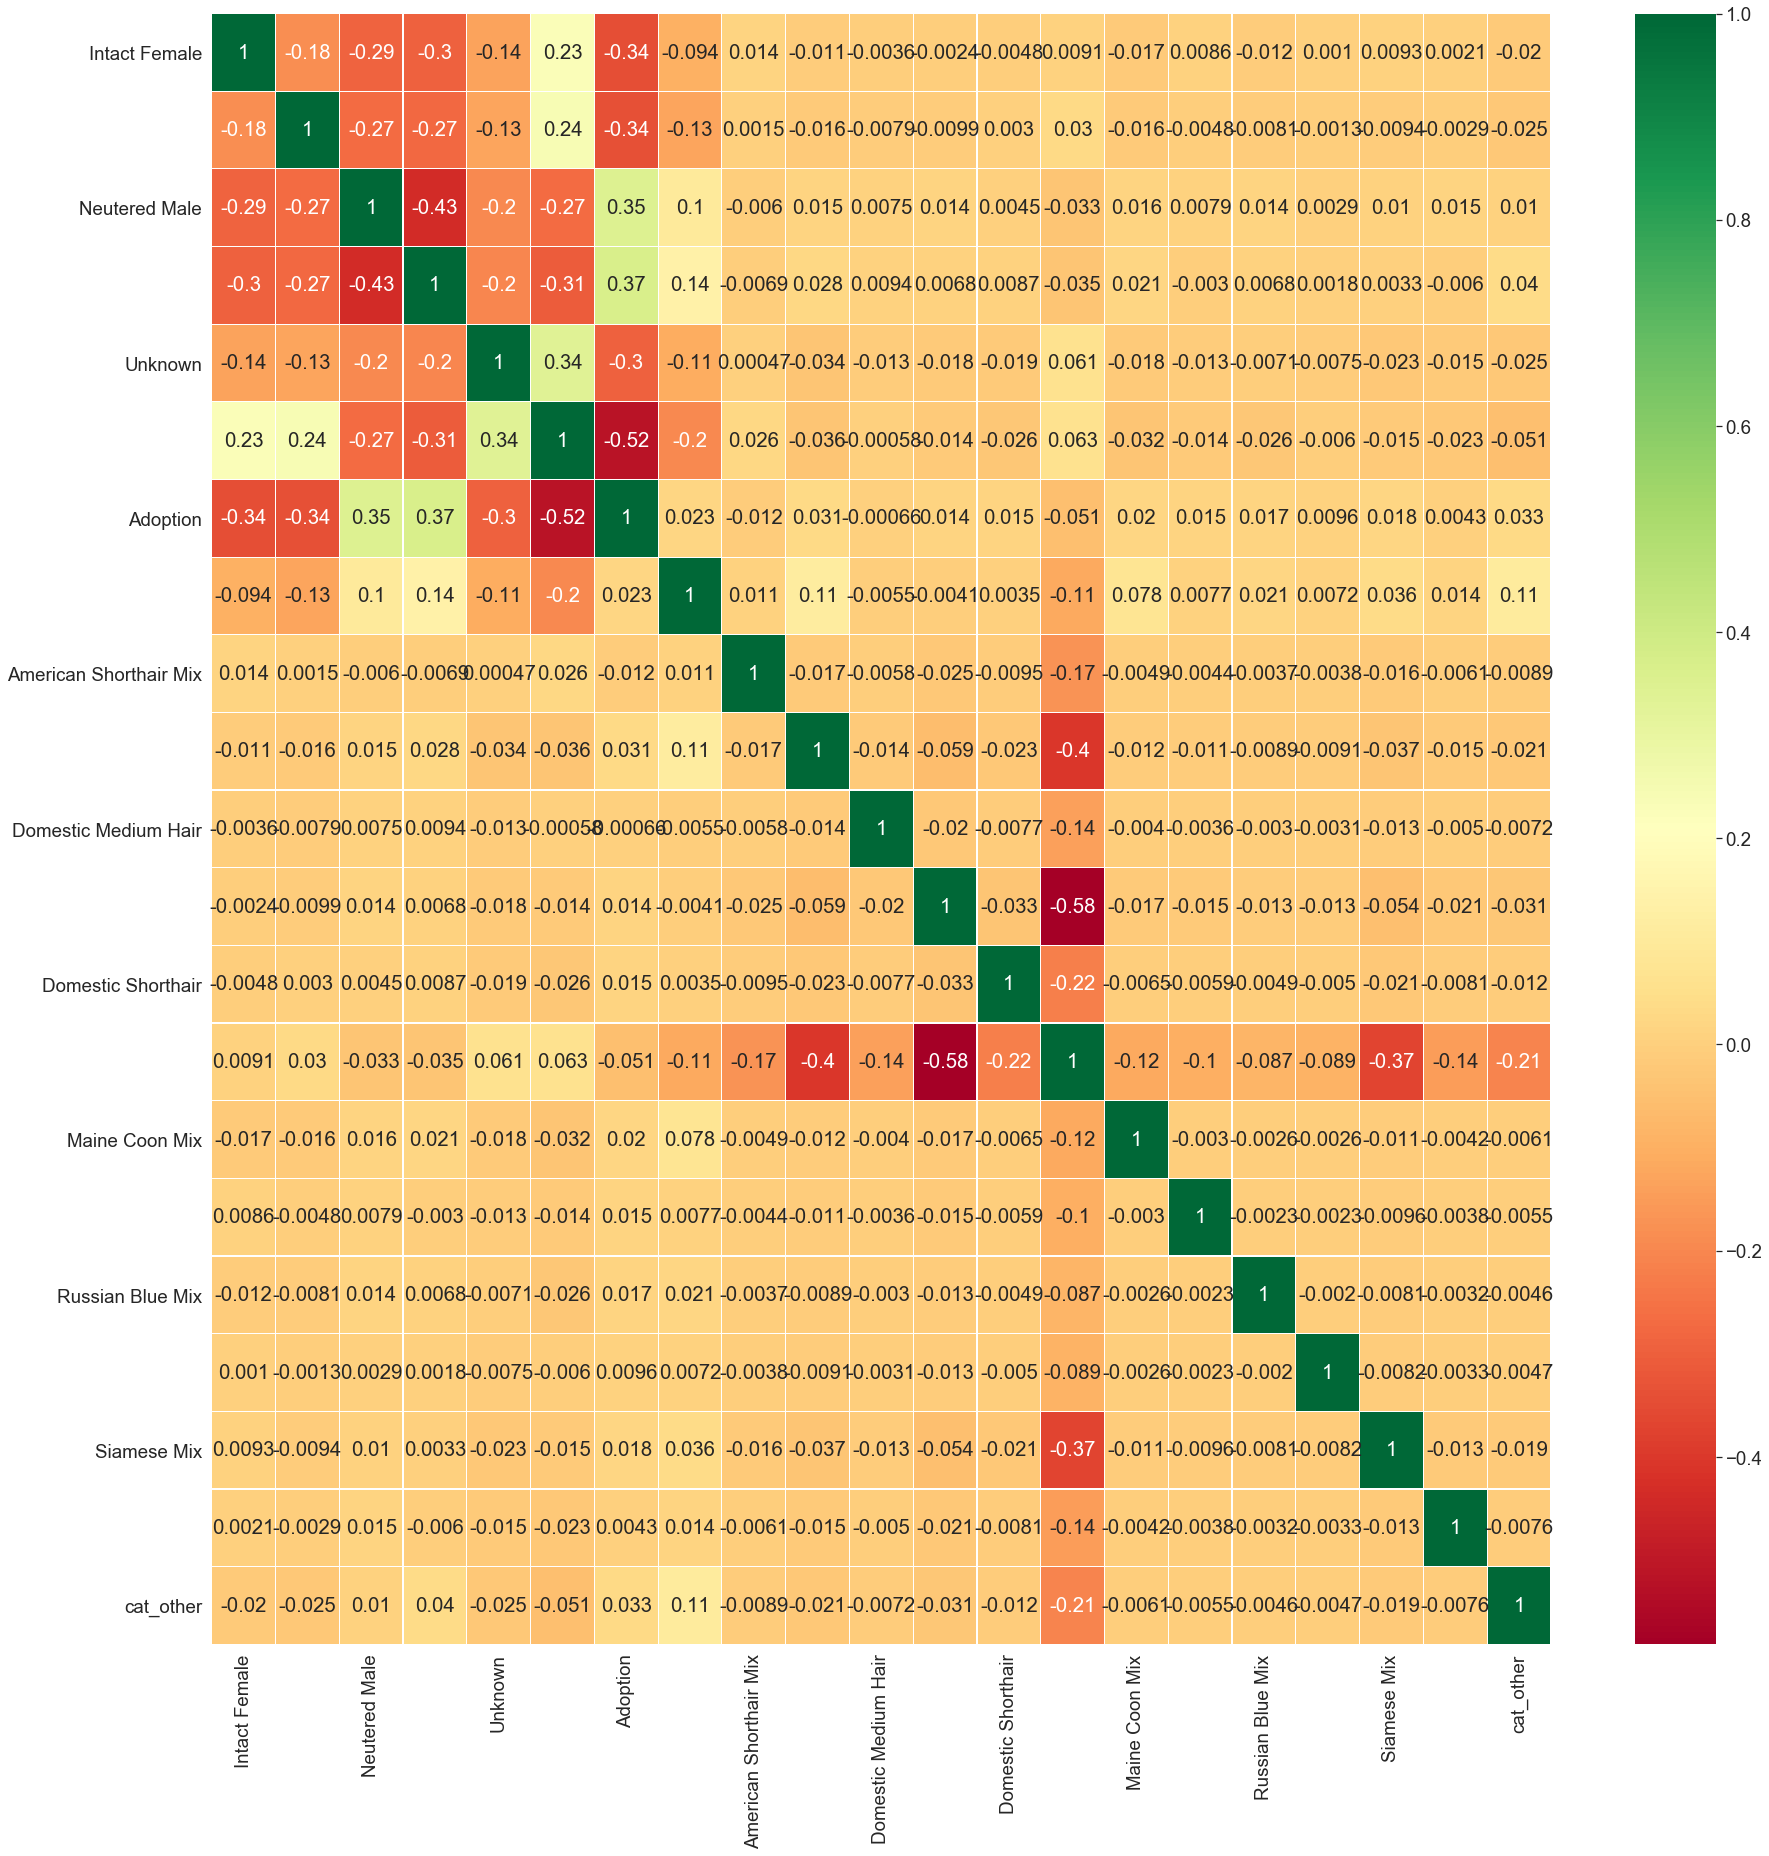

In [42]:
sns.heatmap(cats_data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(30,30)
plt.show()

In [36]:
X = cats_data.drop('Adoption', axis=1)  
y = cats_data['Adoption'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2020, stratify=y)
X

,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown,empty_name,age_weeks,American Shorthair Mix,Domestic Longhair Mix,Domestic Medium Hair,Domestic Medium Hair Mix,Domestic Shorthair,Domestic Shorthair Mix,Maine Coon Mix,Manx Mix,Russian Blue Mix,Siamese,Siamese Mix,Snowshoe Mix,cat_other
0,0.0,1.0,0.0,0.0,0.0,1,2.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0,4.33,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0,12.99,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1,3.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0,8.66,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26050,1.0,0.0,0.0,0.0,0.0,0,8.66,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26051,0.0,1.0,0.0,0.0,0.0,0,4.33,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26052,0.0,0.0,1.0,0.0,0.0,1,52.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26053,0.0,0.0,0.0,1.0,0.0,0,25.98,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print(rfc.score(X_train, y_train))

0.8712029827832


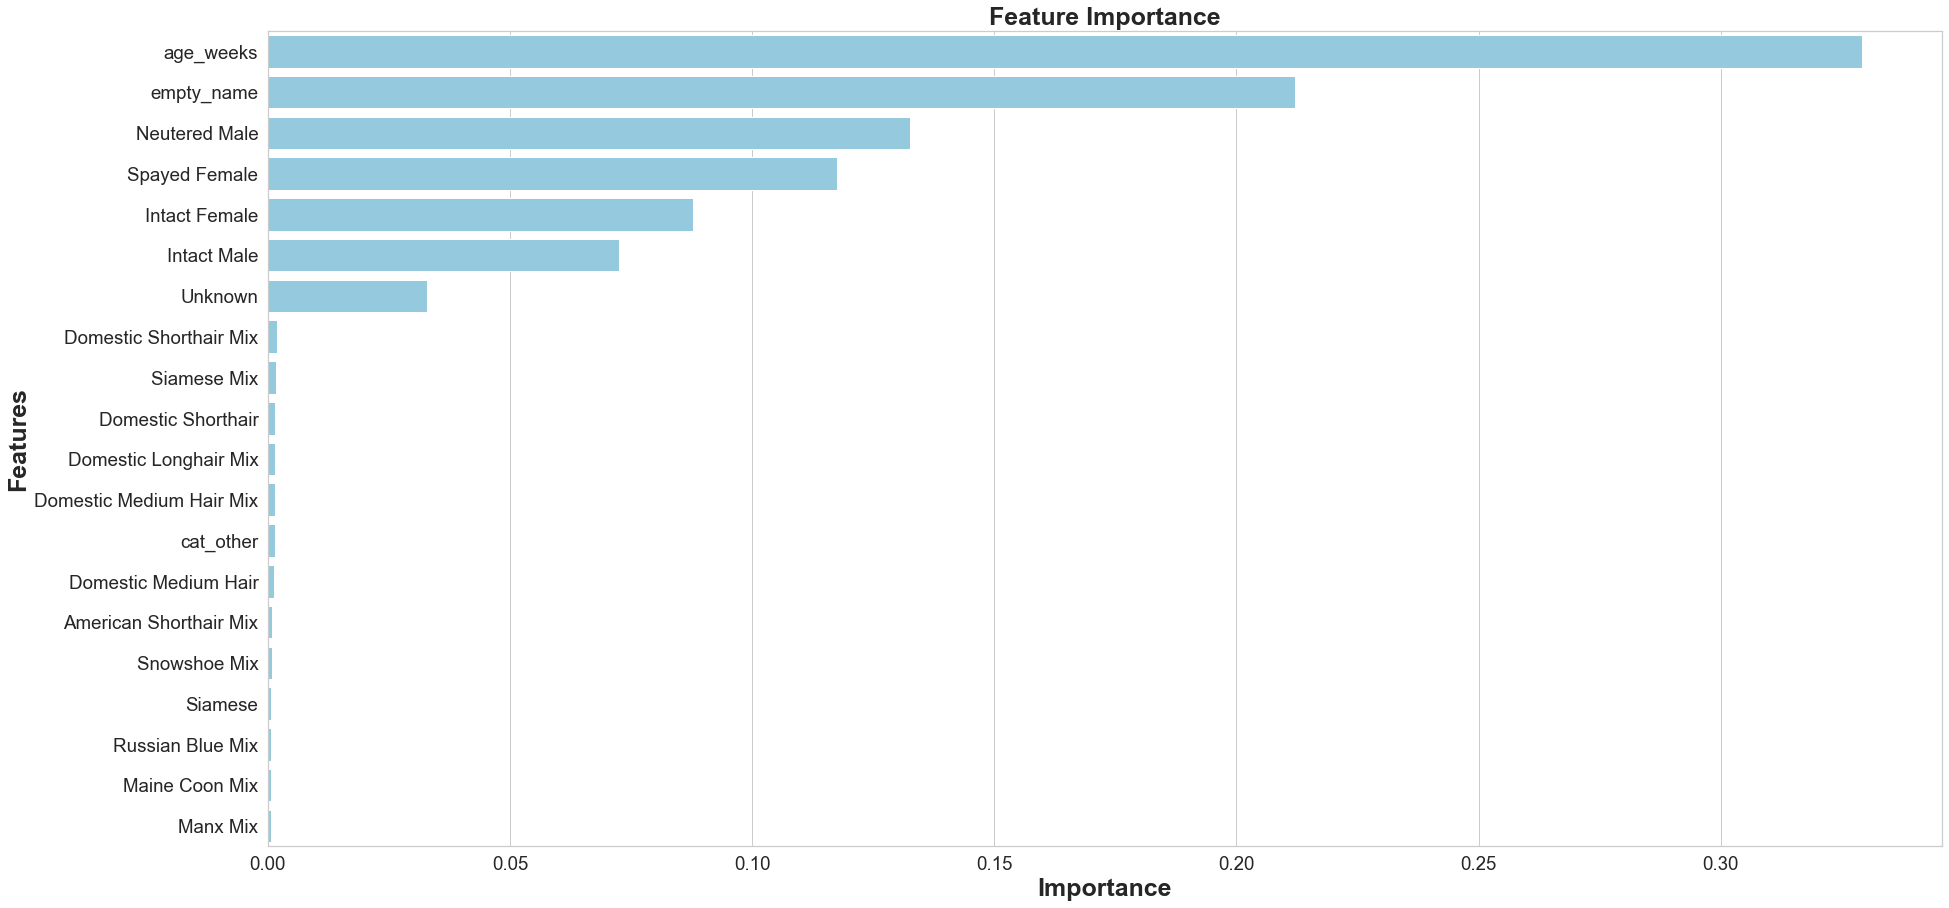

None

,Features,Gini-Importance
0,age_weeks,0.329210
1,empty_name,0.212012
2,Neutered Male,0.132653
3,Spayed Female,0.117632
4,Intact Female,0.087766
5,Intact Male,0.072495
6,Unknown,0.032872
7,Domestic Shorthair Mix,0.001943
8,Siamese Mix,0.001660
9,Domestic Shorthair,0.001538


In [38]:
feats = {}
for feature, importance in zip(X.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

In [39]:
y_pred = rfc.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
# conf_matrix_baseline_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_pca), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
# conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_gs), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(conf_matrix_baseline)
# display('Baseline Random Forest recall score', recall_score(y_test, y_pred))

,predicted 0,predicted 1
actual 0,3130,867
actual 1,272,3548


In [73]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)
display(rfc.score(X_train_scaled, y_train))

0.8712578133567277

In [75]:
y_pred = rfc.predict(X_test_scaled)

from sklearn.metrics import confusion_matrix
conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
# conf_matrix_baseline_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_pca), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
# conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_gs), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(conf_matrix_baseline)
# display('Baseline Random Forest recall score', recall_score(y_test, y_pred))

,predicted 0,predicted 1
actual 0,3140,857
actual 1,297,3523


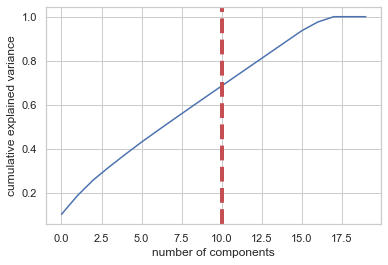

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.102858,0.102858
1,0.188148,0.085291
2,0.259934,0.071786
3,0.319368,0.059433
4,0.376101,0.056734
5,0.430900,0.054799
6,0.482938,0.052037
7,0.534128,0.051191
8,0.584985,0.050857
9,0.635392,0.050407


In [77]:
from sklearn.decomposition import PCA
pca_test = PCA(n_components=20)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [92]:
columns = X_train.columns

pca = PCA(n_components=20)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [93]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=columns, index=pca_dims)
pca_test_df.head(20).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8,PCA Component 9,PCA Component 10,PCA Component 11,PCA Component 12,PCA Component 13,PCA Component 14,PCA Component 15,PCA Component 16,PCA Component 17,PCA Component 18,PCA Component 19
Intact Female,-0.198456,0.246140,-0.032200,0.754703,-0.288208,-0.028612,-0.076200,0.053607,-0.012932,-0.026022,-0.005032,0.011495,-0.019001,-0.021129,-0.005145,0.096922,0.050597,0.202594,4.266370e-01,-9.331733e-04
Intact Male,-0.222822,0.205470,-0.024522,-0.621123,-0.498678,0.163592,-0.035292,0.105562,-0.014113,0.020723,-0.000518,-0.067889,0.013477,0.026057,0.004570,0.043577,0.107598,0.227910,4.029482e-01,-8.813594e-04
Neutered Male,0.227775,-0.187946,0.735606,-0.027061,0.079122,-0.032364,0.017639,-0.030229,0.005776,0.003111,-0.005664,-0.023251,0.023147,-0.038982,0.016115,-0.027987,-0.074936,-0.279682,5.242723e-01,-1.146729e-03
Spayed Female,0.265345,-0.274120,-0.668194,-0.046673,0.070968,-0.139978,0.035737,-0.058349,-0.024723,0.031870,0.014958,0.013954,0.016633,0.007180,-0.012945,-0.051522,-0.076925,-0.293795,5.282484e-01,-1.155426e-03
Unknown,-0.266943,0.174134,-0.028430,-0.103045,0.768036,0.116644,0.058340,-0.058748,0.066589,-0.049277,-0.008080,0.085511,-0.057214,0.047537,-0.003943,-0.053374,0.046972,0.387437,3.189059e-01,-6.975356e-04
empty_name,-0.434468,0.387694,-0.043724,-0.005717,0.115497,0.163756,-0.025000,0.040782,0.028741,-0.002502,-0.000800,-0.026387,-0.032489,0.010864,0.006211,0.029570,0.156634,-0.767068,-4.416973e-16,-1.242794e-17
age_weeks,0.320429,-0.145555,-0.020176,0.078400,0.054724,0.376965,-0.096429,0.160305,0.018728,-0.033400,0.017533,-0.014008,-0.026458,0.005352,0.000183,0.038749,0.827609,0.018851,9.621077e-19,-3.607035e-17
American Shorthair Mix,0.046801,0.128438,-0.017981,0.040440,-0.005937,0.078574,0.046821,0.023011,0.416664,0.389416,0.223908,-0.008937,0.572804,-0.330172,-0.033946,-0.368068,0.004275,0.026596,3.130633e-04,1.431292e-01
Domestic Longhair Mix,0.230238,0.182061,-0.037213,0.027177,-0.009522,0.540151,-0.373430,-0.465837,-0.291127,-0.026085,-0.055405,0.018147,0.030721,-0.044180,-0.003950,-0.042299,-0.248997,-0.001011,7.184044e-04,3.284469e-01
Domestic Medium Hair,0.061702,0.070848,-0.001661,0.008359,0.038601,-0.072939,0.134979,-0.285404,0.176349,0.563563,-0.145105,-0.547415,-0.329340,-0.007252,-0.059519,0.286366,0.077295,0.035500,2.578355e-04,1.178797e-01


In [94]:
y_pred = rfc.predict(X_test_scaled)
y_pred_pca = rfc.predict(X_test_scaled_pca)

In [95]:
from sklearn.metrics import confusion_matrix
conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
conf_matrix_baseline_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_pca), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
# conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_gs), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(conf_matrix_baseline)
display('Baseline Random Forest recall score', recall_score(y_test, y_pred))

,predicted 0,predicted 1
actual 0,3140,857
actual 1,297,3523


'Baseline Random Forest recall score'

0.9222513089005235

In [96]:
display(conf_matrix_baseline_pca)
display('Baseline Random Forest recall score', recall_score(y_test, y_pred_pca))

,predicted 0,predicted 1
actual 0,2742,1255
actual 1,2464,1356


'Baseline Random Forest recall score'

0.3549738219895288

In [ ]:
####################################################################################################

In [13]:
# cats_data['breed'].value_counts()
is_null = data.isnull()
row_has_NaN = is_null.any(axis=1)
rows_with_NaN = data[row_has_NaN]
rows_with_NaN

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
8,1 month,A685067,Cat,Domestic Shorthair Mix,Blue Tabby/White,2014-06-16T00:00:00,2014-08-14T18:45:00,2014-08-14T18:45:00,Lucy,NaN,Adoption,Intact Female
17,3 weeks,A670420,Cat,Domestic Shorthair Mix,Black/White,2013-12-16T00:00:00,2014-01-09T19:29:00,2014-01-09T19:29:00,NaN,Partner,Transfer,Intact Male
19,2 months,A684460,Cat,Domestic Shorthair Mix,Brown Tabby,2014-06-02T00:00:00,2014-08-13T15:04:00,2014-08-13T15:04:00,Elsa,NaN,Adoption,Spayed Female
...,...,...,...,...,...,...,...,...,...,...,...,...
78250,1 month,A764895,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:40:00,2018-02-01T18:40:00,NaN,Foster,Adoption,Neutered Male
78251,1 month,A764894,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:26:00,2018-02-01T18:26:00,NaN,Foster,Adoption,Spayed Female
78252,3 years,A764468,Dog,Mastiff Mix,Blue/White,2014-12-30T00:00:00,2018-02-01T18:06:00,2018-02-01T18:06:00,Max,NaN,Adoption,Neutered Male
78254,2 months,A765858,Dog,Standard Schnauzer,Red,2017-11-13T00:00:00,2018-02-01T18:32:00,2018-02-01T18:32:00,NaN,NaN,Adoption,Spayed Female


In [25]:
from sklearn.datasets import load_breast_cancer
columns = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
dataset = load_breast_cancer()
data = pd.DataFrame(dataset['data'], columns=columns)
data['cancer'] = dataset['target']
# display(data.head())
# display(data.info())
# display(data.isna().sum())
# display(data.describe())
data

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,cancer
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [26]:
from sklearn.model_selection import train_test_split
X = data.drop('cancer', axis=1)  
y = data['cancer'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state = 2020, stratify=y)

In [30]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

array([[ 1.85920686,  0.963565  ,  1.84863136, ...,  1.41760866,
         0.3657918 , -0.30834169],
       [-0.51789918, -0.3074029 , -0.54635738, ..., -0.31231286,
         0.9043777 , -0.87775167],
       [-1.18222767, -0.81218448, -1.15648759, ..., -0.76349225,
        -0.65572067,  0.50424757],
       ...,
       [-0.67143775, -0.47190762, -0.69403977, ..., -0.09333165,
        -0.54112793, -0.75765575],
       [-1.29491401, -0.21726334, -1.28239376, ..., -0.98517694,
        -0.73429855, -0.13686146],
       [ 0.14560677, -1.19527765,  0.23798262, ..., -0.07981429,
        -0.12368292,  0.50365008]])

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)
display(rfc.score(X_train_scaled, y_train))

1.0

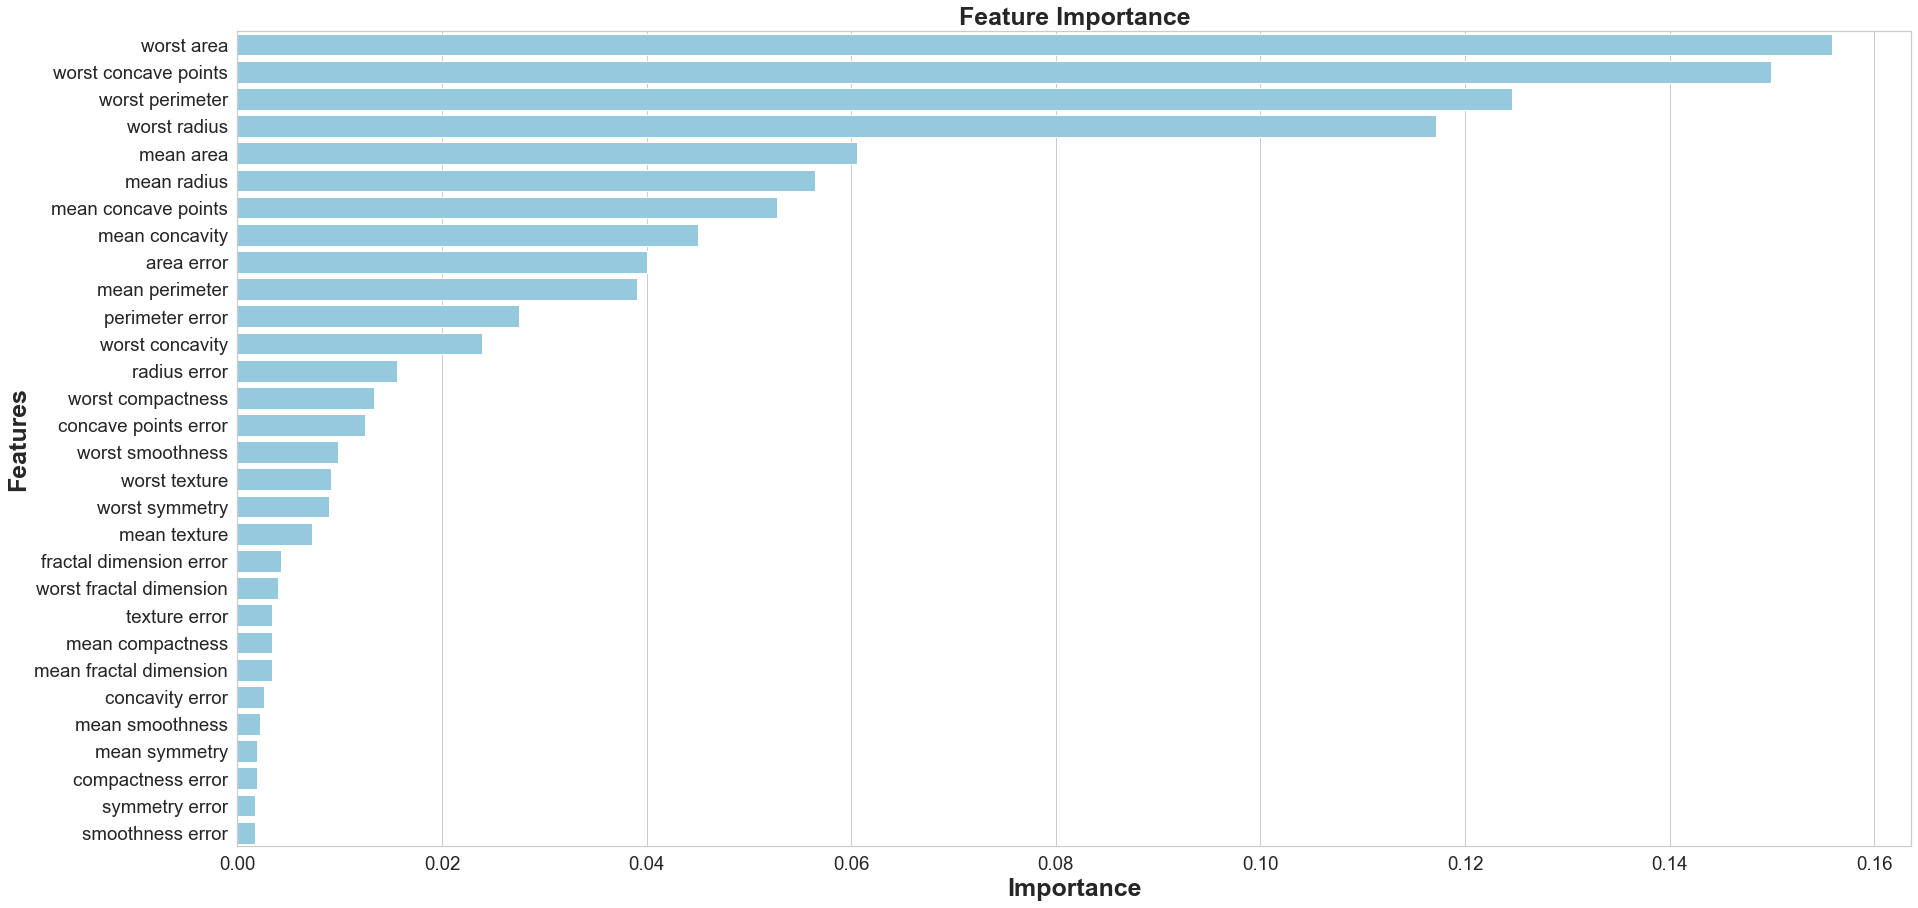

None

,Features,Gini-Importance
0,worst area,0.155840
1,worst concave points,0.149870
2,worst perimeter,0.124622
3,worst radius,0.117129
4,mean area,0.060565
5,mean radius,0.056468
6,mean concave points,0.052783
7,mean concavity,0.045009
8,area error,0.040038
9,mean perimeter,0.039063


In [34]:
feats = {}
for feature, importance in zip(data.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

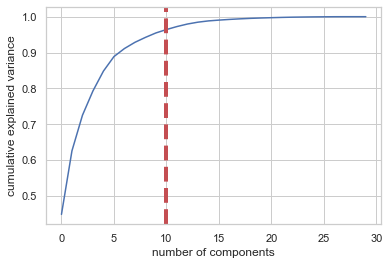

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.448362,0.448362
1,0.625759,0.177397
2,0.724960,0.099201
3,0.792890,0.067930
4,0.848247,0.055357
5,0.888681,0.040435
6,0.911139,0.022457
7,0.928491,0.017353
8,0.942257,0.013766
9,0.954676,0.012419


In [35]:
from sklearn.decomposition import PCA
pca_test = PCA(n_components=30)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [36]:
pca = PCA(n_components=10)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [37]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=columns, index=pca_dims)
pca_test_df.head(10).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8,PCA Component 9
mean radius,0.229757,-0.210916,-0.030019,0.046463,0.033286,0.015126,-0.069528,-0.188402,-0.123401,-0.073688
mean texture,0.101159,-0.069574,0.058763,-0.596565,0.003598,-0.043046,0.063547,0.073671,0.162137,-0.154302
mean perimeter,0.236449,-0.193037,-0.028313,0.047683,0.031936,0.007210,-0.063591,-0.188007,-0.121388,-0.064397
mean area,0.230530,-0.212977,0.013286,0.065251,-0.004611,0.000570,-0.006363,-0.095945,-0.136370,-0.082562
mean smoothness,0.137090,0.205970,-0.031698,0.117614,-0.453585,-0.079954,-0.162701,-0.178166,0.124023,0.384612
mean compactness,0.237018,0.166762,-0.048961,0.023697,-0.001176,-0.064327,0.040522,-0.219044,0.004426,0.042943
mean concavity,0.258283,0.046613,0.015929,0.017595,0.080184,-0.038802,-0.094767,0.066544,-0.072309,0.109753
mean concave points,0.261131,-0.027002,-0.012987,0.044803,-0.054359,-0.032057,-0.145943,-0.175107,-0.062065,0.034035
mean symmetry,0.142589,0.199079,-0.025816,0.011965,-0.171304,0.425826,-0.052532,-0.192594,0.573150,-0.366492
mean fractal dimension,0.048243,0.374409,0.019466,0.052554,-0.125120,-0.206347,0.276034,-0.103717,0.037225,0.121591


In [39]:
y_pred = rfc.predict(X_test_scaled)
# y_pred_pca = rfc.predict(X_test_scaled_pca)


In [41]:
from sklearn.metrics import confusion_matrix
conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
# conf_matrix_baseline_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_pca), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
# conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_gs), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(conf_matrix_baseline)
display('Baseline Random Forest recall score', recall_score(y_test, y_pred))

,predicted 0,predicted 1
actual 0,100,6
actual 1,11,168


'Baseline Random Forest recall score'

0.9385474860335196